In [1]:
import torch
import pandas as pd
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms
import torchvision.models as models
from torchvision.datasets import ImageFolder
from torch.utils.data import random_split, DataLoader
from tqdm import tqdm
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

In [2]:
from google.colab import drive
drive.mount('/content/drive')

train_dir = "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Splitted_dataset/train"
val_dir = "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Splitted_dataset/val"
test_dir = "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Splitted_dataset/test"

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Found 7 class folders:
- akiec
- bcc
- bkl
- df
- mel
- nv
- vasc

--- Displaying first 4 images for class: akiec ---

--- Displaying first 4 images for class: bcc ---

--- Displaying first 4 images for class: bkl ---

--- Displaying first 4 images for class: df ---

--- Displaying first 4 images for class: mel ---

--- Displaying first 4 images for class: nv ---

--- Displaying first 4 images for class: vasc ---


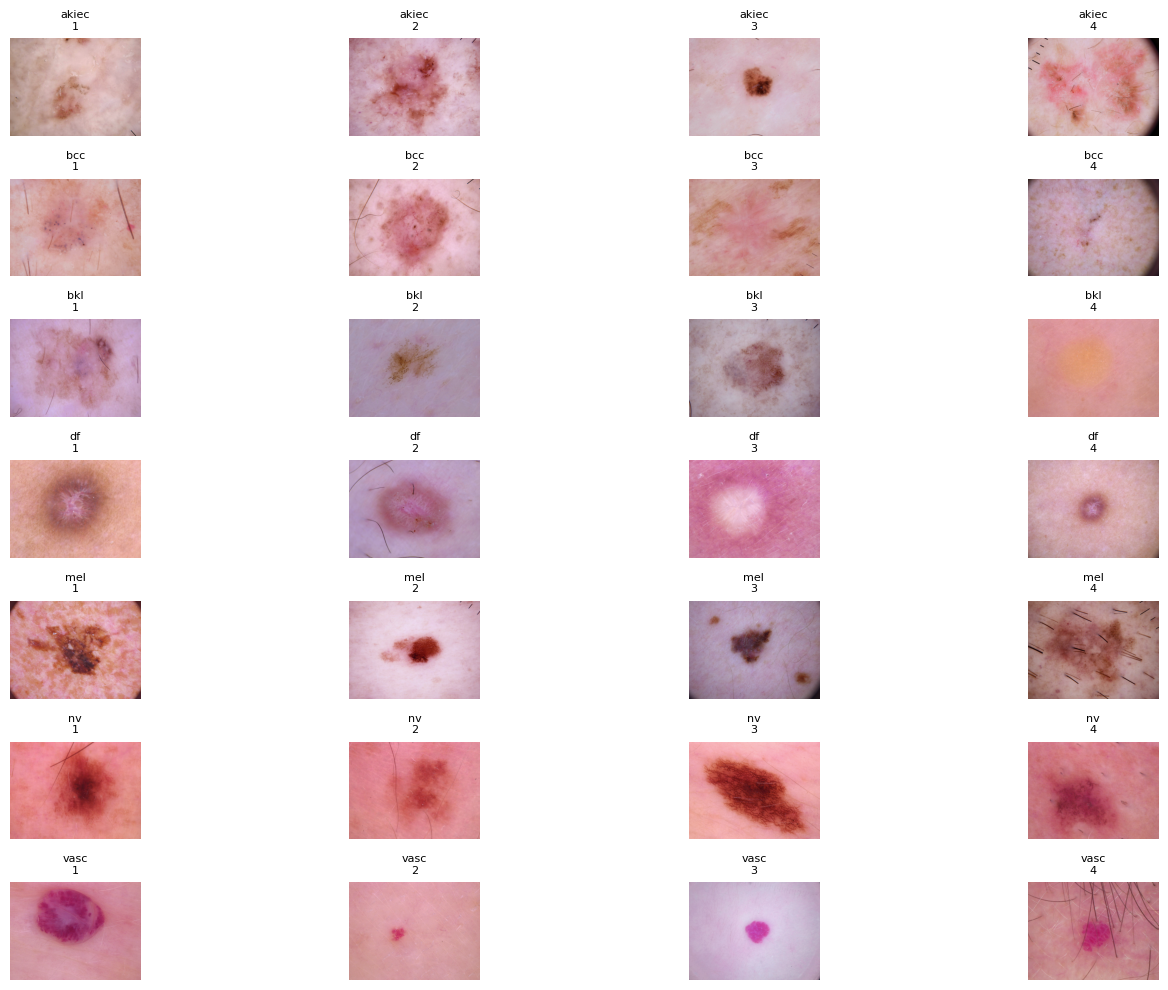


Finished displaying images.


In [3]:
import os
from PIL import Image
import matplotlib.pyplot as plt

# Make sure your Google Drive is mounted first!
# from google.colab import drive
# drive.mount('/content/drive') # Run this if you haven't already in your session

# Define the root directory where your class folders are located
# This is the path you provided:
BASE_IMAGE_DIR = '/content/drive/MyDrive/Research paper on cnn and ensemble learning/Dataset/Folder according to classes'

# Get a list of all class folders (subdirectories)
class_folders = [d for d in os.listdir(BASE_IMAGE_DIR) if os.path.isdir(os.path.join(BASE_IMAGE_DIR, d))]
class_folders.sort() # Sort to ensure consistent order

print(f"Found {len(class_folders)} class folders:")

for folder in class_folders:
    print(f"- {folder}")

# Set up the plot for displaying images
plt.figure(figsize=(15, 10)) # Adjust figure size as needed

# Iterate through each class folder
for i, class_name in enumerate(class_folders):
    class_path = os.path.join(BASE_IMAGE_DIR, class_name)

    # Get a list of all image files in the current class folder
    # Filter for common image extensions (you can add more if needed)
    image_files = [f for f in os.listdir(class_path) if f.lower().endswith(('.png', '.jpg', '.jpeg', '.gif', '.bmp'))]
    image_files.sort() # Sort to get consistent "first 4"

    print(f"\n--- Displaying first 4 images for class: {class_name} ---")

    # Display the first 4 images (or fewer if less than 4 exist)
    for j in range(min(4, len(image_files))):
        img_name = image_files[j]
        img_path = os.path.join(class_path, img_name)

        try:
            img = Image.open(img_path).convert('RGB')

            # Subplot setup: 7 rows (for classes), 4 columns (for images)
            plt.subplot(len(class_folders), 4, (i * 4) + j + 1)
            plt.imshow(img)
            plt.title(f"{class_name}\n{j+1}", fontsize=8)
            plt.axis('off') # Hide axes for cleaner display

        except Exception as e:
            print(f"Could not load image {img_path}: {e}")
            # If an image fails to load, draw an empty plot to maintain layout
            plt.subplot(len(class_folders), 4, (i * 4) + j + 1)
            plt.text(0.5, 0.5, "Image Error", horizontalalignment='center', verticalalignment='center', transform=plt.gca().transAxes, color='red')
            plt.axis('off')


plt.tight_layout() # Adjust subplot parameters for a tight layout
plt.show()

print("\nFinished displaying images.")

In [4]:
torch.manual_seed(42)

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device

device(type='cpu')

In [6]:
train_transforms = transforms.Compose([
    transforms.Resize((256, 256)),   ## Resize the images to 256x256
    transforms.RandomResizedCrop(224, scale=(0.8, 1.0)),   ## Adding random crop to 224x224
    transforms.RandomHorizontalFlip(p=0.5),   ## adding random flips left and right
    transforms.RandomVerticalFlip(p=0.5), ## vertical
transforms.RandomRotation(20),  # ±20 degrees - more realistic variations
transforms.ColorJitter(
    brightness=0.3,   # added more
    contrast=0.3,     # added more
    saturation=0.2,   #
    hue=0.1          #
),
transforms.RandomAffine(degrees=0, translate=(0.1, 0.1)),
transforms.RandomPerspective(distortion_scale=0.2, p=0.3),
transforms.RandomErasing(p=0.3, scale=(0.02, 0.15))
    transforms.ToTensor(),  ## converting the images to tensors
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])  ## normalizzing according to resnet34 mean and std values
])

val_test_transforms = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])

])

SyntaxError: invalid syntax. Perhaps you forgot a comma? (ipython-input-1947694090.py, line 15)

In [ ]:
train_dataset = ImageFolder(root=train_dir, transform=train_transforms)
val_dataset = ImageFolder(root=val_dir, transform=val_test_transforms)
test_dataset = ImageFolder(root=test_dir, transform=val_test_transforms)  ## used val and text transformer for 2 dataset

In [ ]:
print(len(train_dataset))

print(len(val_dataset))
print(len(test_dataset))

## 8010 + 998 + 1007 = 1000015

In [ ]:
img, label = train_dataset[0]
print(f"Label: {label}, image_tensor: {img}")

In [7]:
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=4)
val_loader = DataLoader(val_dataset, batch_size=64, shuffle=False, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False, num_workers=4)

NameError: name 'train_dataset' is not defined

In [ ]:
model = models.resnet34(pretrained=True)
model = model.to(device)

/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.12/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet34_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet34_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 124MB/s]


In [ ]:
for param in model.parameters():
    param.requires_grad = False

In [ ]:
model.fc = nn.Linear(model.fc.in_features, 7)

model = model.to(device)

In [ ]:
# from sklearn.utils.class_weight import compute_class_weight
# import numpy as np

# # Get class weights
# class_weights = compute_class_weight(class_weight='balanced',
#                                      classes=np.unique(train_dataset.targets),
#                                      y=train_dataset.targets)

# # Convert to tensor and move to device
# class_weights_tensor = torch.tensor(class_weights, dtype=torch.float).to(device)

# # Use with CrossEntropyLoss
# criterion = nn.CrossEntropyLoss(weight=class_weights_tensor)

In [ ]:
class FocalLoss(nn.Module):
    def __init__(self, alpha=0.25, gamma=2.0, reduction='mean'):
        super(FocalLoss, self).__init__()
        self.alpha = alpha
        self.gamma = gamma
        self.reduction = reduction

    def forward(self, inputs, targets):
        ce_loss = F.cross_entropy(inputs, targets, reduction='none')
        pt = torch.exp(-ce_loss)
        loss = self.alpha * (1 - pt) ** self.gamma * ce_loss
        return loss.mean() if self.reduction == 'mean' else loss.sum()


In [ ]:

from torch.optim.lr_scheduler import ReduceLROnPlateau


criterion = FocalLoss(alpha=0.25, gamma=2.0)

optimizer = optim.Adam(
    model.fc.parameters(),
    lr=1e-4,
    weight_decay=3e-6
)


scheduler = ReduceLROnPlateau(
    optimizer,
    mode='max',
    patience=3,
    factor=0.5
)

In [ ]:
from sklearn.metrics import f1_score
from tqdm import tqdm

train_losses, val_losses = [], []
train_accuracies, val_accuracies = [], []
val_f1_scores = []

epochs = 30
best_f1 = 0.0

for epoch in range(epochs):
    print(f"\nEpoch {epoch + 1}/{epochs}")
    print("-" * 40)
    model.train()

    running_loss = 0.0
    correct = 0
    total = 0

    # ================= TRAINING ==================
    for imgs, labels in tqdm(train_loader, desc="Training"):
        imgs, labels = imgs.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = model(imgs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_loader)
    train_acc = correct / total
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)
    print(f"Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}")

    # ================= VALIDATION ==================
    model.eval()
    val_loss = 0.0
    val_correct = 0
    val_total = 0
    all_preds, all_labels = [], []

    with torch.no_grad():
        for imgs, labels in tqdm(val_loader, desc="Validating"):
            imgs, labels = imgs.to(device), labels.to(device)
            outputs = model(imgs)
            loss = criterion(outputs, labels)

            val_loss += loss.item()
            _, preds = torch.max(outputs, 1)
            val_correct += (preds == labels).sum().item()
            val_total += labels.size(0)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    val_loss /= len(val_loader)
    val_acc = val_correct / val_total
    val_f1 = f1_score(all_labels, all_preds, average='weighted')

    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    val_f1_scores.append(val_f1)

    print(f"Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f} | Val F1: {val_f1:.4f}")

    # Step the LR scheduler based on F1 (since mode='max')
    scheduler.step(val_f1)

    # ================= SAVE BEST MODEL ==================
    if val_f1 > best_f1:
        best_f1 = val_f1
        torch.save(model.state_dict(), "/content/drive/MyDrive/Research paper on cnn and ensemble learning/Models/resnet34_best.pth")
        print("✅ Model improved and saved!")

print("\n🎯 Training Complete!")
print(f"Best Validation F1-score: {best_f1:.4f}")



Epoch 1/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:43<00:00,  1.22it/s]


Train Loss: 0.1681 | Train Acc: 0.6604


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


Val Loss: 0.1813 | Val Acc: 0.6132 | Val F1: 0.5583
✅ Model improved and saved!

Epoch 2/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Train Loss: 0.1580 | Train Acc: 0.6669


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.54it/s]


Val Loss: 0.1678 | Val Acc: 0.6343 | Val F1: 0.5877
✅ Model improved and saved!

Epoch 3/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:47<00:00,  1.17it/s]


Train Loss: 0.1472 | Train Acc: 0.6752


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.51it/s]


Val Loss: 0.1581 | Val Acc: 0.6393 | Val F1: 0.5979
✅ Model improved and saved!

Epoch 4/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:46<00:00,  1.19it/s]


Train Loss: 0.1402 | Train Acc: 0.6788


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Val Loss: 0.1483 | Val Acc: 0.6453 | Val F1: 0.6013
✅ Model improved and saved!

Epoch 5/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Train Loss: 0.1335 | Train Acc: 0.6883


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


Val Loss: 0.1406 | Val Acc: 0.6623 | Val F1: 0.6231
✅ Model improved and saved!

Epoch 6/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:48<00:00,  1.16it/s]


Train Loss: 0.1294 | Train Acc: 0.6946


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


Val Loss: 0.1326 | Val Acc: 0.6693 | Val F1: 0.6286
✅ Model improved and saved!

Epoch 7/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Train Loss: 0.1244 | Train Acc: 0.6956


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


Val Loss: 0.1284 | Val Acc: 0.6673 | Val F1: 0.6343
✅ Model improved and saved!

Epoch 8/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:43<00:00,  1.21it/s]


Train Loss: 0.1207 | Train Acc: 0.6960


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


Val Loss: 0.1238 | Val Acc: 0.6814 | Val F1: 0.6514
✅ Model improved and saved!

Epoch 9/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:45<00:00,  1.20it/s]


Train Loss: 0.1175 | Train Acc: 0.7039


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Val Loss: 0.1231 | Val Acc: 0.6754 | Val F1: 0.6550
✅ Model improved and saved!

Epoch 10/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Train Loss: 0.1161 | Train Acc: 0.7061


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


Val Loss: 0.1153 | Val Acc: 0.6944 | Val F1: 0.6624
✅ Model improved and saved!

Epoch 11/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Train Loss: 0.1125 | Train Acc: 0.7117


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


Val Loss: 0.1121 | Val Acc: 0.7024 | Val F1: 0.6742
✅ Model improved and saved!

Epoch 12/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Train Loss: 0.1097 | Train Acc: 0.7196


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


Val Loss: 0.1106 | Val Acc: 0.7084 | Val F1: 0.6753
✅ Model improved and saved!

Epoch 13/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Train Loss: 0.1069 | Train Acc: 0.7238


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


Val Loss: 0.1093 | Val Acc: 0.7094 | Val F1: 0.6758
✅ Model improved and saved!

Epoch 14/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Train Loss: 0.1082 | Train Acc: 0.7175


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.59it/s]


Val Loss: 0.1056 | Val Acc: 0.7134 | Val F1: 0.6892
✅ Model improved and saved!

Epoch 15/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Train Loss: 0.1045 | Train Acc: 0.7251


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.70it/s]


Val Loss: 0.1037 | Val Acc: 0.7174 | Val F1: 0.6853

Epoch 16/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Train Loss: 0.1035 | Train Acc: 0.7326


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


Val Loss: 0.1011 | Val Acc: 0.7275 | Val F1: 0.7001
✅ Model improved and saved!

Epoch 17/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Train Loss: 0.1026 | Train Acc: 0.7295


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


Val Loss: 0.1007 | Val Acc: 0.7285 | Val F1: 0.7017
✅ Model improved and saved!

Epoch 18/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Train Loss: 0.1009 | Train Acc: 0.7306


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


Val Loss: 0.1000 | Val Acc: 0.7275 | Val F1: 0.7056
✅ Model improved and saved!

Epoch 19/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:47<00:00,  1.17it/s]


Train Loss: 0.1008 | Train Acc: 0.7293


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.56it/s]


Val Loss: 0.0972 | Val Acc: 0.7355 | Val F1: 0.7123
✅ Model improved and saved!

Epoch 20/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Train Loss: 0.0991 | Train Acc: 0.7375


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.46it/s]


Val Loss: 0.0967 | Val Acc: 0.7305 | Val F1: 0.7090

Epoch 21/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Train Loss: 0.0995 | Train Acc: 0.7360


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.52it/s]


Val Loss: 0.0958 | Val Acc: 0.7335 | Val F1: 0.7099

Epoch 22/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:46<00:00,  1.18it/s]


Train Loss: 0.0965 | Train Acc: 0.7411


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.50it/s]


Val Loss: 0.0959 | Val Acc: 0.7335 | Val F1: 0.7162
✅ Model improved and saved!

Epoch 23/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Train Loss: 0.0985 | Train Acc: 0.7401


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.49it/s]


Val Loss: 0.0955 | Val Acc: 0.7375 | Val F1: 0.7042

Epoch 24/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Train Loss: 0.0965 | Train Acc: 0.7423


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.47it/s]


Val Loss: 0.0943 | Val Acc: 0.7445 | Val F1: 0.7235
✅ Model improved and saved!

Epoch 25/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Train Loss: 0.0970 | Train Acc: 0.7396


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.71it/s]


Val Loss: 0.0944 | Val Acc: 0.7445 | Val F1: 0.7333
✅ Model improved and saved!

Epoch 26/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:45<00:00,  1.19it/s]


Train Loss: 0.0953 | Train Acc: 0.7397


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.45it/s]


Val Loss: 0.0923 | Val Acc: 0.7435 | Val F1: 0.7233

Epoch 27/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Train Loss: 0.0941 | Train Acc: 0.7467


Validating: 100%|██████████| 16/16 [00:11<00:00,  1.43it/s]


Val Loss: 0.0929 | Val Acc: 0.7515 | Val F1: 0.7274

Epoch 28/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Train Loss: 0.0938 | Train Acc: 0.7454


Validating: 100%|██████████| 16/16 [00:10<00:00,  1.48it/s]


Val Loss: 0.0936 | Val Acc: 0.7465 | Val F1: 0.7355
✅ Model improved and saved!

Epoch 29/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.20it/s]


Train Loss: 0.0942 | Train Acc: 0.7476


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.73it/s]


Val Loss: 0.0916 | Val Acc: 0.7465 | Val F1: 0.7236

Epoch 30/30
----------------------------------------


Training:   0%|          | 0/126 [00:00<?, ?it/s]/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(
Training: 100%|██████████| 126/126 [01:44<00:00,  1.21it/s]


Train Loss: 0.0925 | Train Acc: 0.7487


Validating: 100%|██████████| 16/16 [00:09<00:00,  1.67it/s]


Val Loss: 0.0917 | Val Acc: 0.7525 | Val F1: 0.7251

🎯 Training Complete!
Best Validation F1-score: 0.7355


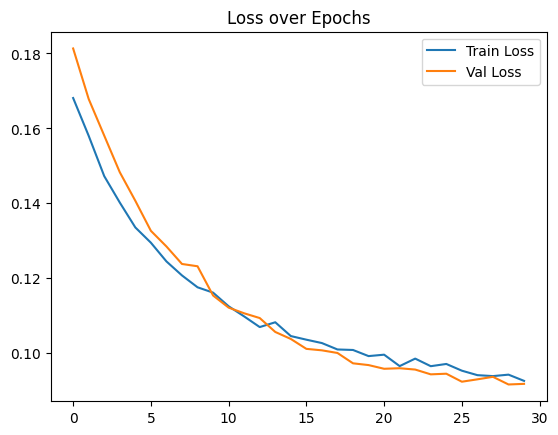

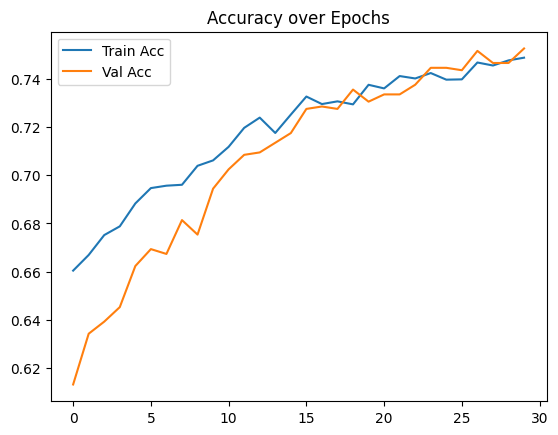

In [ ]:
import matplotlib.pyplot as plt

plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.legend()
plt.title('Loss over Epochs')
plt.show()

plt.plot(train_accuracies, label='Train Acc')
plt.plot(val_accuracies, label='Val Acc')
plt.legend()
plt.title('Accuracy over Epochs')
plt.show()

In [ ]:
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
import json
import numpy as np

# ==============================
# 1️⃣ Load Best Model
# ==============================
model.load_state_dict(torch.load("/content/drive/MyDrive/Research paper on cnn and ensemble learning/Models/resnet34_best.pth", map_location=device))
model.eval()

# ==============================
# 2️⃣ Evaluate on Test Set
# ==============================
all_preds, all_labels = [], []

with torch.no_grad():
    for imgs, labels in tqdm(test_loader, desc="Testing"):
        imgs, labels = imgs.to(device), labels.to(device)
        outputs = model(imgs)
        preds = torch.argmax(outputs, 1)
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# ==============================
# 3️⃣ Compute Metrics
# ==============================
test_acc = accuracy_score(all_labels, all_preds)
test_f1 = f1_score(all_labels, all_preds, average='weighted')
cm = confusion_matrix(all_labels, all_preds)

print(f"\n📊 Test Accuracy: {test_acc:.4f}")
print(f"📈 Test F1-score: {test_f1:.4f}")
print("\nClassification Report:")
print(classification_report(all_labels, all_preds))

# ==============================
# 4️⃣ Save Metrics for Ensemble Weighting
# ==============================
metrics = {
    "model": "resnet34",
    "test_accuracy": float(test_acc),
    "test_f1": float(test_f1)
}

with open("/content/drive/MyDrive/Research paper on cnn and ensemble learning/Results/metrics_resnet34.json", "w") as f:
    json.dump(metrics, f, indent=4)

print("\n✅ Metrics saved to metrics_resnet34.json")


Testing: 100%|██████████| 16/16 [03:33<00:00, 13.35s/it]



📊 Test Accuracy: 0.7587
📈 Test F1-score: 0.7449

Classification Report:
              precision    recall  f1-score   support

           0       0.40      0.12      0.18        34
           1       0.56      0.62      0.59        52
           2       0.52      0.56      0.54       111
           3       0.00      0.00      0.00        12
           4       0.47      0.48      0.48       112
           5       0.87      0.91      0.89       671
           6       1.00      0.20      0.33        15

    accuracy                           0.76      1007
   macro avg       0.55      0.41      0.43      1007
weighted avg       0.75      0.76      0.74      1007


✅ Metrics saved to metrics_resnet34.json


In [ ]:
save_path = "/content/drive/MyDrive/models/"

In [ ]:
import os
os.makedirs(save_path, exist_ok=True)

In [ ]:
torch.save(model.state_dict(), os.path.join(save_path, f"model_epoch_{epoch+1}.pth"))

In [ ]:
model = model.load()

AttributeError: 'ResNet' object has no attribute 'load'

In [ ]:
model.eval()

total = 0.0
correct = 0.0
total_loss = 0.0


with torch.no_grad():
  for imgs, labels in tqdm(test_loader):
    imgs, labels = imgs.to(device), labels.to(device)

    output = model(imgs)

    loss = criterion(output, labels)
    total_loss = total_loss + loss.item()

    _, predict = torch.max(output, 1)
    total += labels.size(0)


    correct += (predict == labels).sum().item()

accuracy = correct/total
avg_loss = total/len(test_loader)
print(f"Accuracy: {accuracy * 100} with average loss {avg_loss}")

In [ ]:
torch.save(model, "/content/drive/MyDrive/models/Skin_cancer_detection_full_model.pth")

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10,5))
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.figure(figsize=(10,5))
plt.plot(train_accuracies, label="Train Accuracy")
plt.plot(val_accuracies, label="Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()


In [ ]:
##

In [ ]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Run model on your test/validation set to get predictions
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for inputs, labels in test_loader:
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        y_true.extend(labels.numpy())
        y_pred.extend(preds.numpy())

# Confusion matrix
cm = confusion_matrix(y_true, y_pred)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=all_labels,
            yticklabels=all_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()




In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(12,5))

plt.subplot(1,2,1)
plt.plot(epochs, train_losses, 'b-', label='Training Loss')
plt.plot(epochs, val_losses, 'r-', label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.title('Loss over Epochs')

plt.subplot(1,2,2)
plt.plot(epochs, train_accuracies, 'b-', label='Training Accuracy')
plt.plot(epochs, val_accuracies, 'r-', label='Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.title('Accuracy over Epochs')

plt.show()


In [ ]:
# Next from here

In [ ]:
# 1:35 – 1:50 | Lessons Learned
# Narration:
# "This project taught me more than just coding. I learned patience, the importance of checkpoints, and how a good training strategy can turn a hopeless model into a reliable one."
# Visuals:
# Checklist: “Patience ✅, Checkpoints ✅, Better Strategy ✅”

In [ ]:
import torch
import matplotlib.pyplot as plt

# Load models
model1 = torch.load("/content/drive/MyDrive/models/Skin_cancer_detection_full_model.pth", map_location=torch.device('cpu'), weights_only=False)
model2 = torch.load("/content/drive/MyDrive/models/Skin_cancer_detection.pth", map_location=torch.device('cpu'), weights_only=False)



device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model1.to(device)
model2.to(device)


def evaluate_model(model, val_loader):
    model.eval()
    total_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for inputs, targets in val_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            total_loss += loss.item() * inputs.size(0)
            _, predicted = torch.max(outputs.data, 1)
            correct += (predicted == targets).sum().item()
            total += targets.size(0)
    avg_loss = total_loss / total
    accuracy = correct / total
    return avg_loss, accuracy

# Assuming you want to compare models on the same validation data for one epoch
loss1, acc1 = evaluate_model(model1, val_loader)
loss2, acc2 = evaluate_model(model2, val_loader)

# If you want to do multiple epochs, you need to loop over epochs and store losses/accuracies accordingly
# Here I’ll just plot a bar chart comparison since only one point per model is available:

labels = ['Model 1', 'Model 2']
losses = [loss1, loss2]
accuracies = [acc1, acc2]

plt.figure(figsize=(10,5))

plt.subplot(1,2,1)
plt.bar(labels, losses, color=['blue','orange'])
plt.title("Validation Loss Comparison")
plt.ylabel("Loss")

plt.subplot(1,2,2)
plt.bar(labels, accuracies, color=['blue','orange'])
plt.title("Validation Accuracy Comparison")
plt.ylabel("Accuracy")

plt.show()


TypeError: 'ellipsis' object is not iterable

In [ ]:
plt.figure(figsize=(10,5))
plt.plot(val_losses_model1, label="Model 1 Validation Loss")
plt.plot(val_losses_model2, label="Model 2 Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Validation Loss Comparison")
plt.show()

plt.figure(figsize=(10,5))
plt.plot(val_accuracies_model1, label="Model 1 Validation Accuracy")
plt.plot(val_accuracies_model2, label="Model 2 Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Validation Accuracy Comparison")
plt.show()


NameError: name 'val_losses_model1' is not defined

<Figure size 1000x500 with 0 Axes>